In [46]:
# !pip install azure-storage-blob
# !pip install python-dotenv

import os
from dotenv import load_dotenv
from setup_utils import fetch_data, load_data, create_time_index
import pandas as pd
import numpy as np

CONNECTION_STRING = os.getenv("CONNECTION_STRING")

load_dotenv()
fetch_data(CONNECTION_STRING)

(
    brand_mapping,
    macro_data,
    brand_constraint,
    pack_constraint,
    segment_constraint,
    sales_data,
    volume_variation_constraint,
) = load_data()

(
    macro_data,
    sales_data,
) = create_time_index([macro_data, sales_data])


data/brand_segment_mapping_hackathon.xlsx
data/macro_data.xlsx
data/maximum_discount_constraint_hackathon.xlsx
data/sales_data_hackathon.xlsx
data/volume_variation_constraint_hackathon.xlsx
data/submission_template_hackathon.csv


In [47]:
from sklearn.metrics import make_scorer, r2_score

In [48]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [49]:
target_sku_list = sales_data[sales_data.gto.isna()].sku.unique()
target_brand_list = sales_data[sales_data.gto.isna()][["sku", "brand"]].brand.unique()

In [50]:
k = sales_data[["sku", "brand"]].drop_duplicates().groupby("sku").apply(lambda x: set(x.brand.unique()))#[target_sku_list]
k2 = sales_data[["sku", "brand"]].drop_duplicates().groupby("sku").apply(lambda x: x.brand.nunique()>1)

issue_skus = k[k2].drop_duplicates().to_list()

brand_date_range = sales_data.fillna(0).reset_index().groupby("brand").apply(lambda x: pd.Series([x.date.min(), x.date.max()], index=["min", "max"]))
brand_date_range = brand_date_range.to_dict()

In [51]:
# [(tuple(i)[0] in target_brand_list, tuple(i)[1] in target_brand_list) for i in issue_skus]
# sales_data[["sku", "brand"]].drop_duplicates().groupby("brand").apply(lambda x: x.sku.nunique())[list(set.union(*issue_skus))]
# [(brand_date_range["max"][tuple(i)[0]], brand_date_range["max"][tuple(i)[1]]) for i in issue_skus]
# [(brand_date_range["min"][tuple(i)[0]], brand_date_range["min"][tuple(i)[1]]) for i in issue_skus]

In [52]:
# sales_data.reset_index().groupby(["date", "brand"]).volume.sum().unstack(1).T.loc[target_brand_list]

In [53]:
# sales_data.reset_index().groupby(["date", "sku"]).volume.sum().unstack(1).T

In [54]:
df = sales_data.reset_index().groupby(["date"])[["volume", "net_revenue", "promotional_discount", "other_discounts"]].sum().sort_index().join(macro_data)
k = df.net_revenue.shift(1)
k.name = "shifted_nr"
df = df.join(k).fillna(method="bfill")

In [55]:
import tensorflow as tf

In [56]:
data = df.iloc[:-2].copy(deep=True)

scaled_cols = ["net_revenue", "promotional_discount", "other_discounts", "shifted_nr"]#, "private_consumption", "gross_domestic_saving", "brnd_money", "gdp", "shifted_nr"]
scaler = data.net_revenue.mean()
data.loc[:,scaled_cols] = data.loc[:,scaled_cols]/scaler


mixed_effect_cols = ["retail_sales_index", "unemployment_rate", "cpi", "private_consumption", "gross_domestic_saving", "brad_money", "gdp"]

data.loc[:, mixed_effect_cols] = data.loc[:, mixed_effect_cols].divide(data.loc[:, mixed_effect_cols].mean())-1

In [57]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.enable_eager_execution()

In [63]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

In [64]:
sess = tf.compat.v1.Session()

# Y
# y = tf.constant(data.net_revenue, dtype=tf.float64)
# discounts = -tf.constant(data[["promotional_discount", "other_discounts"]].values, dtype=tf.float64)
# mixed_effect = tf.constant(data[mixed_effect_cols].values, dtype=tf.float64)
# time_index = tf.constant(np.arange(1, data.shape[0]+1), dtype=tf.float64)
# shifted_nr = tf.constant(data.shifted_nr, dtype=tf.float64)

#Y
y = tf.compat.v1.placeholder(dtype=tf.float64, name="y_actual")

# X
shifted_nr = tf.compat.v1.placeholder(dtype=tf.float64, name="shifted_nr")
discounts = tf.compat.v1.placeholder(dtype=tf.float64, name="discounts")
mixed_effect = tf.compat.v1.placeholder(dtype=tf.float64, name="mixed_effects")
time_index = tf.compat.v1.placeholder(dtype=tf.float64, name="time_index")



# variables
baseline_intercept = tf.Variable(1, dtype=tf.float64)
baseline_slope1 = tf.Variable(1, dtype=tf.float64)
baseline_slope2 = tf.Variable(1, dtype=tf.float64)
mixed_effect_mult = tf.Variable(np.random.normal(loc=1, size=(1, 7)), dtype=tf.float64)
discount_slope = tf.math.sigmoid(tf.Variable(np.random.normal(loc=-1, size=(1, 2)), dtype=tf.float64))*3
roi_mults = tf.Variable(np.random.normal(loc=1, size=(1, 7)), dtype=tf.float64)

variable_list = [baseline_intercept, baseline_slope1, baseline_slope2, mixed_effect_mult, discount_slope]

# impacts
base1 = tf.multiply(baseline_slope1, time_index) + baseline_intercept
base2 = base1# + tf.multiply(baseline_slope2, shifted_nr)
mixed_effect_impact = 1 + tf.nn.tanh(tf.multiply(mixed_effect, mixed_effect_mult))
total_mixed_effect_impact = tf.reduce_prod(mixed_effect_impact, axis=1)
discount_impact = tf.multiply(discount_slope, discounts)
roi_mult_impact = 1 + tf.nn.tanh(tf.multiply(mixed_effect_impact, roi_mults))
total_roi_mult_impact = tf.expand_dims(tf.reduce_prod(roi_mult_impact, axis=1), axis=1)

# prediction
y_pred = (
    tf.multiply(base2, total_mixed_effect_impact)
    + tf.reduce_sum(discount_impact, axis=1)
)

# loss
wape = tf.reduce_sum(tf.math.abs(y - y_pred))/tf.reduce_sum(y)
mse = tf.reduce_sum(tf.math.square(y - y_pred))
reg = sum([tf.reduce_sum(tf.square(i)) for i in variable_list])

loss = 1e3*wape + 1e2*mse + reg

In [65]:
feed_dict1 = {
    discounts : -data[["promotional_discount", "other_discounts"]].iloc[:-5,:].astype(np.float64).values,
    mixed_effect: data[mixed_effect_cols].iloc[:-5,:].astype(np.float64).values,
    shifted_nr : data["shifted_nr"].iloc[:-5].astype(np.float64).values,
    y : data["net_revenue"].iloc[:-5].astype(np.float64).values,
    time_index : np.float64(np.arange(1, data.iloc[:-5,:].shape[0]+1)),
}

feed_dict2 = {
    discounts : -data[["promotional_discount", "other_discounts"]].iloc[-5:,:].astype(np.float64).values,
    mixed_effect: data[mixed_effect_cols].iloc[-5:,:].astype(np.float64).values,
    shifted_nr : data["shifted_nr"].iloc[-5:].astype(np.float64).values,
    y : data["net_revenue"].iloc[-5:].astype(np.float64).values,
    time_index : np.float64(np.arange(1, data.iloc[-5:,:].shape[0]+1)),
}

In [66]:
epoch = 0
# optimizer
lr = lambda x : 0.1 / np.power(x/100 + 10, 2 / 3)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr(epoch))#, beta1=0.1, beta2=0.1)
train = optimizer.minimize(loss)

# initialize variables
init = tf.compat.v1.global_variables_initializer()
sess.run(init, feed_dict1)

In [62]:
# train model
num_epochs = 30000
for epoch in range(num_epochs):
    _, current_loss, current_wape, current_mse, current_reg = sess.run([train, loss, wape, mse, reg], feed_dict1)
    if (epoch + 1) % 250 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {current_loss:.4f}, WAPE: {current_wape:.4f}, MSE: {current_mse:.4f}, reg: {current_reg:.4f}")


#         # Training loop
# num_epochs = 500
# for epoch in range(num_epochs):
#     _, current_error, cuurent_mse, current_m1, current_m2, current_c = sess.run([train_op, error, mse_error, m1, m2, c])
#     if (epoch + 1) % 25 == 0:
#         print(f"Epoch {epoch + 1}/{num_epochs}, Error: {current_error:.4f}, MSE: {cuurent_mse:.4f}, m1: {current_m1}, m2: {current_m2}, c: {current_c}")

# # Print the final results for 'm' and 'c'
# final_m1, final_m2, final_c = sess.run([m1, m2, c])
# print(f"Final 'm1' value: {final_m1}")

# print(f"Final 'm2' value: {final_m2}")
# print(f"Final 'c' value: {final_c}")

Epoch 250/30000, Loss: 1012.1704, WAPE: 0.3009, MSE: 6.9663, reg: 14.6864
Epoch 500/30000, Loss: 917.5502, WAPE: 0.2879, MSE: 6.1463, reg: 14.9932
Epoch 750/30000, Loss: 813.9463, WAPE: 0.2725, MSE: 5.2583, reg: 15.6164
Epoch 1000/30000, Loss: 710.8809, WAPE: 0.2537, MSE: 4.4033, reg: 16.8145
Epoch 1250/30000, Loss: 617.2780, WAPE: 0.2336, MSE: 3.6494, reg: 18.7156
Epoch 1500/30000, Loss: 541.0920, WAPE: 0.2148, MSE: 3.0545, reg: 20.8322
Epoch 1750/30000, Loss: 478.8786, WAPE: 0.1972, MSE: 2.5905, reg: 22.6336
Epoch 2000/30000, Loss: 426.7940, WAPE: 0.1808, MSE: 2.2200, reg: 24.0146
Epoch 2250/30000, Loss: 382.0084, WAPE: 0.1653, MSE: 1.9165, reg: 25.0524
Epoch 2500/30000, Loss: 345.2227, WAPE: 0.1526, MSE: 1.6680, reg: 25.8052
Epoch 2750/30000, Loss: 317.1107, WAPE: 0.1435, MSE: 1.4731, reg: 26.3115
Epoch 3000/30000, Loss: 291.2362, WAPE: 0.1343, MSE: 1.3028, reg: 26.6813
Epoch 3250/30000, Loss: 267.2287, WAPE: 0.1250, MSE: 1.1529, reg: 26.9391
Epoch 3500/30000, Loss: 244.8819, WAPE: 

In [67]:
# train model
num_epochs = 30000
for epoch in range(num_epochs):
    _, current_loss, current_wape, current_mse, current_reg = sess.run([train, loss, wape, mse, reg], feed_dict1)
    if (epoch + 1) % 250 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {current_loss:.4f}, WAPE: {current_wape:.4f}, MSE: {current_mse:.4f}, reg: {current_reg:.4f}")


#         # Training loop
# num_epochs = 500
# for epoch in range(num_epochs):
#     _, current_error, cuurent_mse, current_m1, current_m2, current_c = sess.run([train_op, error, mse_error, m1, m2, c])
#     if (epoch + 1) % 25 == 0:
#         print(f"Epoch {epoch + 1}/{num_epochs}, Error: {current_error:.4f}, MSE: {cuurent_mse:.4f}, m1: {current_m1}, m2: {current_m2}, c: {current_c}")

# # Print the final results for 'm' and 'c'
# final_m1, final_m2, final_c = sess.run([m1, m2, c])
# print(f"Final 'm1' value: {final_m1}")

# print(f"Final 'm2' value: {final_m2}")
# print(f"Final 'c' value: {final_c}")

Epoch 250/30000, Loss: 800.8982, WAPE: 0.2701, MSE: 5.1996, reg: 10.8298
Epoch 500/30000, Loss: 557.7445, WAPE: 0.2158, MSE: 3.3097, reg: 10.9690
Epoch 750/30000, Loss: 369.4071, WAPE: 0.1615, MSE: 1.9670, reg: 11.2121
Epoch 1000/30000, Loss: 271.6997, WAPE: 0.1235, MSE: 1.3669, reg: 11.4932
Epoch 1250/30000, Loss: 247.6462, WAPE: 0.1150, MSE: 1.2102, reg: 11.6699
Epoch 1500/30000, Loss: 244.0953, WAPE: 0.1147, MSE: 1.1761, reg: 11.7443
Epoch 1750/30000, Loss: 243.0375, WAPE: 0.1146, MSE: 1.1670, reg: 11.7657
Epoch 2000/30000, Loss: 242.2569, WAPE: 0.1142, MSE: 1.1631, reg: 11.7651
Epoch 2250/30000, Loss: 241.3654, WAPE: 0.1137, MSE: 1.1586, reg: 11.7652
Epoch 2500/30000, Loss: 240.3281, WAPE: 0.1133, MSE: 1.1526, reg: 11.7655
Epoch 2750/30000, Loss: 239.0956, WAPE: 0.1128, MSE: 1.1453, reg: 11.7668
Epoch 3000/30000, Loss: 237.5696, WAPE: 0.1122, MSE: 1.1360, reg: 11.7711
Epoch 3250/30000, Loss: 235.5137, WAPE: 0.1114, MSE: 1.1232, reg: 11.7843
Epoch 3500/30000, Loss: 232.2320, WAPE: 0

In [126]:
np.absolute(sess.run(y, feed_dict1)-sess.run(y_pred, feed_dict1)).sum()/sess.run(y, feed_dict1).sum()

0.08797747328630161

In [127]:
np.absolute(sess.run(y, feed_dict2)-sess.run(y_pred, feed_dict2)).sum()/sess.run(y, feed_dict2).sum()

0.26187125074172957

In [128]:
r2_score(sess.run(y, feed_dict1), sess.run(y_pred, feed_dict1))

0.7897377733268196

<AxesSubplot: >

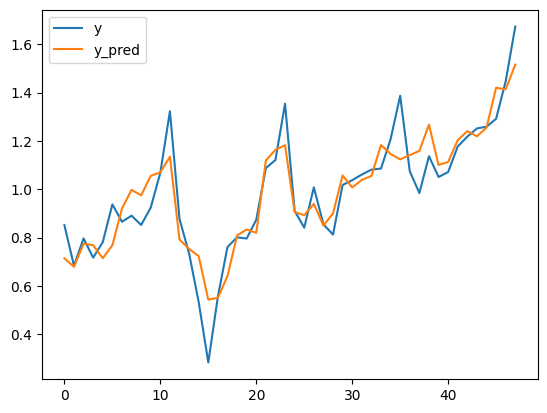

In [120]:
pd.DataFrame({"y":sess.run(y, feed_dict1), "y_pred" : sess.run(y_pred, feed_dict1)}).plot()

In [46]:
sess.run(variable_list, feed_dict)

[0.5658123127221157,
 0.012648105272455436,
 0.012648105272455436,
 array([[ 0.05793168,  0.41117514, -1.28255388,  3.62075937,  2.36638921,
          0.61491021, -3.07556298]]),
 array([[5.03275515e-01, 1.56839525e-10]])]

In [47]:
# pd.DataFrame(sess.run([base1, base2-base1, tf.multiply(base2, mixed_effect_impact)-base2, tf.reduce_sum(discount_impact, axis=1)])).T.plot()

In [ ]:
# # Import the necessary libraries
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import MinMaxScaler

# # Generate or load your dataset
# X, y = df.iloc[:-2, 2:], df.iloc[:-2, 1]

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a MinMaxScaler and fit it to the training data
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Create a linear regression model
# model = LinearRegression()

# # Fit the model to the scaled training data
# model.fit(X_train_scaled, y_train)

# # Make predictions on the scaled test data
# y_pred = model.predict(X_test_scaled)

# # Calculate and print performance metrics
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Mean Squared Error:", mse)
# print("R-squared:", r2)

# # Optionally, you can also access the model's coefficients and intercept
# coefficients = model.coef_
# intercept = model.intercept_

# print("Coefficients:", coefficients)
# print("Intercept:", intercept)
